
[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [83]:
# ML workflow: preparing data -> creating model -> optimizing parameters -> saving model
# Working with data
# PyTorch has two primitives to work with data: torch.utils.data.Dataset stores the samples and their corresponding labels, and 
# torch.utils.data.DataLoader{(N, C, H, W), (N, y)} wraps an iterable batch around the Dataset{N, (C, X_H, X_W, y)}.
import torch
from torch import nn
from torch.utils.data import DataLoader

# Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.
from torchvision import datasets # torch.utils.data.Dataset objects
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [51]:
# Download training data from open datastets
# type(training_data).__mro__ = (torchvision.datasets.mnist.FashionMNIST, torchvision.datasets.mnist.MNIST,
#                                 torchvision.datasets.vision.VisionDataset, torch.utils.data.dataset.Dataset,
#                                   typing.Generic, object)
# len(training_data) = 60000, type(training_data[0]) = tuple
# training_data[0] = (tensor([[28*28]]),9) -> tuple, the first element of the tuple is tensor because of transform=ToTensor()
# training_data[0][0].shape = torch.Size([1, 28, 28]), consisted of float between 0~1
training_data = datasets.FashionMNIST( 
    root="../nlpcode/nlpdatahub",
    train=True,
    download=True,
    transform=ToTensor(),
)

#Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="../nlpcode/nlpdatahub",
    train=False,
    download=True,
    transform=ToTensor(),

)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [52]:
batch_size = 64

# Create data loaders X, y iterator.
# type(train_dataloader).__mro__ = ((torch.utils.data.dataloader.DataLoader, typing.Generic, object))
# len(train_dataloader.dataset) = 60000, len(train_dataloader) = 60000/64 = 938 b atches, 
# iterator to list: list(train_dataloader) = [[tensor_X, tensor_y],...,num=938]
# Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]), Shape of y: torch.Size([64]) torch.int64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break # 只循环一次

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [58]:
# Creating Models
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# To define a neural network in PyTorch, we create a class that inherits from nn.Module. 
# Define Model
class NeuralNetwork(nn.Module):
    def __init__(self): # define the layers of the network 
        super(NeuralNetwork, self).__init__()  
        self.flatten = nn.Flatten() # NCHW([64, 1, 28, 28]) -> flatten(1, -1) = (64 , 28*28)
        # 前馈神经网络模型：y = f(𝒘T𝒙 + 𝑏)，f()为神经元的非线性激活函数，wT为神经元权重
        # 非线性激活函数ReLU=max(0, x)用于中间层，非线性激活函数Sigmoid->(0,1)用于最后的概率值输出层
        # 每个/层神经元由权重linear_wT和激活函数ReLU(或Sigmoid)构成，本例中为三层神经网络(两个ReLU+一个漏了的的用于输出的Sigmoid)
        # 输入层flatten -> 3个隐藏层Linear -> 输出层sigmoid
        self.linear_relu_stack = nn.Sequential(  # input: 64 batches X_(28*28)
            nn.Linear(28*28, 512),               # 64 batches {X_(28*28) . wT_(28*28,512) + b_(512)-> y_(512)}
            nn.ReLU(),                           # 64 batches {y_(512)-> y_(512)}
            nn.Linear(512, 512),                 # 64 batches {X_(512) . wT_(512,512) + b_(512)-> y_(512)}
            nn.ReLU(),                           # 64 batches {y_(512)-> y_(512)}
            nn.Linear(512, 10),                  # 64 batches {X_(512) . wT_(512,10) + b_(10)-> y_(10)}
            # nn.Sigmoid()                       # output: 64 batches {y_(10)}  
            # nn.Softmax(dim=1)     
        )
        # 本例中忘记加入的Sigmoid函数(sigmoid可以放在放在模型中或者forward中)
        # 64 batches Sigmoid_{y_(10)-> y_(10)}  
        
        # 查看各层神经网络中的参数：权重和偏差
        # for name, param in model.named_parameters():
        #     print(name, param.shape)
        # 
        # linear_relu_stack.0.weight torch.Size([512, 784]) -> Linear(28*28, 512), Linear值也即权重系数矩阵转置后的wT值
        # linear_relu_stack.0.bias torch.Size([512])        -> Linear.bias(512)
        # linear_relu_stack.2.weight torch.Size([512, 512]) -> Linear(512, 512),
        # linear_relu_stack.2.bias torch.Size([512])        -> Linear.bias(512)
        # linear_relu_stack.4.weight torch.Size([10, 512])  -> Linear(512, 10) 
        # linear_relu_stack.4.bias torch.Size([10])         -> Linear.bias(10)
        #                   4.bias = list(model.parameters())[5] = tensor([ 0.0398, -0.0169, -0.0100,  0.0044,  
        #                        -0.0198, 0.0174, -0.0120,  0.0384, 0.0268, -0.0440], device='cuda:0', requires_grad=True)
        # above model.parameters() value is also what in model.pth and model.state_dict()
        
    def forward(self, x): # specify how data will pass through the network, x.shape = torch.Size([64, 1, 28, 28]) one batch
        x = self.flatten(x) # x.shape = torch.Size([64, 784])
        logits = self.linear_relu_stack(x) # logit.shape = torch.Size([64, 10])
        # logits[0] = tensor([ 0.1264, -0.0450,  0.0593,  0.0600, -0.0301,  0.0103,  0.0152,  0.1127,
        #                              0.0805, -0.1390], device='cuda:0', grad_fn=<SelectBackward0>)
        # logits概率值中有负数是因为最后一层没有使用Sigmiod激活函数限制值的范围到(0,1),
        # 或者说没有softmax函数限制(0,1)且和为1(更像概率值)
        # logits = torch.sigmoid(logits)
        return logits

# move to GPU, To accelerate operations in the neural network
model = NeuralNetwork().to(device)
print(model)

Using cuda:0 device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [59]:
from torch.utils.tensorboard import SummaryWriter
#在tensorboard中查看模型
writer = SummaryWriter('./data/tensorboard')
writer.add_graph(model, input_to_model = next(iter(train_dataloader))[0].to(device))
writer.close()

In [4]:
# 查看torchscript生成的IR graph表示和code表示
import torch
@torch.jit.script
def foo(len):
  # type: (int) -> torch.Tensor
  rv = torch.zeros(3, 4)
  for i in range(len):
    if i < 10:
        rv = rv - 1.0
    else:
        rv = rv + 1.0
  return rv

print(foo.graph)
print(foo.code)

graph(%len.1 : int):
  %21 : int = prim::Constant[value=1]()
  %13 : bool = prim::Constant[value=1]() # /tmp/ipykernel_2042247/2032849203.py:7:2
  %5 : NoneType = prim::Constant()
  %1 : int = prim::Constant[value=3]() # /tmp/ipykernel_2042247/2032849203.py:6:19
  %2 : int = prim::Constant[value=4]() # /tmp/ipykernel_2042247/2032849203.py:6:22
  %16 : int = prim::Constant[value=10]() # /tmp/ipykernel_2042247/2032849203.py:8:11
  %20 : float = prim::Constant[value=1.]() # /tmp/ipykernel_2042247/2032849203.py:9:18
  %4 : int[] = prim::ListConstruct(%1, %2)
  %rv.1 : Tensor = aten::zeros(%4, %5, %5, %5, %5) # /tmp/ipykernel_2042247/2032849203.py:6:7
  %rv : Tensor = prim::Loop(%len.1, %13, %rv.1) # /tmp/ipykernel_2042247/2032849203.py:7:2
    block0(%i.1 : int, %rv.29 : Tensor):
      %17 : bool = aten::lt(%i.1, %16) # /tmp/ipykernel_2042247/2032849203.py:8:7
      %rv.27 : Tensor = prim::If(%17) # /tmp/ipykernel_2042247/2032849203.py:8:4
        block0():
          %rv.5 : Tensor = aten:

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [5]:
# Optimizing the Model Parameters
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [6]:
# a single training loop, the model makes predictions, backpropagates the prediction error, adjust the model’s parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # size = 60000
    model.train() # Sets the module in training mode
    for batch, (X, y) in enumerate(dataloader): 
        X, y = X.to(device), y.to(device) # X.shape = torch.Size([64, 1, 28, 28]), y.shape = torch.Size([64])
        
        # Compute prediction error
        pred = model(X) # pred.shape = torch.Size([64, 10]), 64 batches
        # pred[0] = tensor([ 0.1264, -0.0450,  0.0593,  0.0600, -0.0301,  0.0103,  0.0152,  0.1127,
        #                              0.0805, -0.1390], device='cuda:0', grad_fn=<SelectBackward0>)
        # pred概率值中有负数是因为最后一层没有使用Sigmiod激活函数限制值的范围到(0,1)
        
        loss = loss_fn(pred, y) # type(loss) = 'torch.Tensor', len(loss) = 1
        # loss = tensor(2.3079, device='cuda:0', grad_fn=<NllLossBackward0>)

        #3 Backpropagation
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero.
        loss.backward() # Computes the gradient of current tensor('loss') w.r.t. graph leaves
        # every tensor has a grad attribute (None by default and becomes a Tensor 
        # the first time a call to backward computes gradients for self.  
        # and a grad_fn prop in which there stores tensors it is derived from
        # ;
        # When we do loss.backward() the process of backpropagation starts at the loss 
        # and goes through all of its parents all the way to model inputs parameter's grad attribute
        optimizer.step() # Performs a single optimization step (parameter tensor update).
        # use their(parameter's) internally stored grad to update their values.

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]") # 检验loss是否有被优化、是否在下降

We also check the model's performance against the test dataset to ensure it is learning.



In [7]:
#  check the model’s performance against the test dataset to ensure it is learning.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) 
    num_batches = len(dataloader)
    model.eval() # Sets the module in evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad(): # Context-manager that disabled gradient calculatio
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 预测正确的个数
            # torch.argmax() :Returns the indices of the maximum values of a tensor across a dimension
            # pred[0] = tensor([[-2.5338, -2.6526, -0.8845, -2.1145, -0.8406,  2.5560, -1.0434,  2.8125, 1.8455,  3.1938]])
            # pred.shape = torch.Size([64, 10])
            # pred.argmax(1).shape = torch.Size([64])
            # (pred.argmax(1) == y).shape = torch.Size([64]) consisted of True or False
            # (pred.argmax(1) == y).type(torch.float) consisted of 1. or 2.0
            # .sum().item() 计算预测正确的个数
    test_loss /= num_batches # n个batch的平均损失
    correct /= size # 正确率
    # to see the accuracy increase and the loss decrease with every epoch.
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [8]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
# Accuracy: 64.6%, Avg loss: 1.106282
# Accuracy: 70.9%, Avg loss: 0.783265 (epoch=20)
# with sigmoid Accuracy: 45.5%, Avg loss: 2.245753
# with softmax Accuracy: 10.4%, Avg loss: 2.294693 

Epoch 1
-------------------------------
loss: 2.287906    [    0/60000]
loss: 2.278855    [ 6400/60000]
loss: 2.262914    [12800/60000]
loss: 2.268467    [19200/60000]
loss: 2.235638    [25600/60000]
loss: 2.212586    [32000/60000]
loss: 2.215851    [38400/60000]
loss: 2.175164    [44800/60000]
loss: 2.177122    [51200/60000]
loss: 2.147410    [57600/60000]
Test Error: 
 Accuracy: 44.0%, Avg loss: 2.139662 

Epoch 2
-------------------------------
loss: 2.144533    [    0/60000]
loss: 2.132601    [ 6400/60000]
loss: 2.074656    [12800/60000]
loss: 2.100196    [19200/60000]
loss: 2.038900    [25600/60000]
loss: 1.982468    [32000/60000]
loss: 2.010017    [38400/60000]
loss: 1.924220    [44800/60000]
loss: 1.933917    [51200/60000]
loss: 1.862314    [57600/60000]
Test Error: 
 Accuracy: 53.9%, Avg loss: 1.853933 

Done!


Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [11]:
# Saving Models
torch.save(model.state_dict(), "model.pth") #  serialize the internal state dictionary (containing the model parameters)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [13]:
# Loading Models: re-creating the model structure and loading the state dictionary into it
model = NeuralNetwork() # re-creating the model structure
model.load_state_dict(torch.load("model.pth")) # loading the state dictionary, torch.load() Loads an object saved with torch.save from a file. 
# type(torch.load("model.pth")) = collections.OrderedDict
# model.pth, model.state_dict(), model.parameters()
# optimizer.param_groups[0]['params']中包含的都是所有网络层中的权重系数矩阵和偏差矩阵的值

<All keys matched successfully>

This model can now be used to make predictions.



In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()


x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y] # pred[0].argmax(0) = pred.argmax(1)[0]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your model](saveloadrun_tutorial.html).




# 二、入门教程pytorch basic
## tensor

In [3]:
#  In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.
import torch
# Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs,  optimized for automatic differentiation - Autograd 
# In fact, tensors and NumPy arrays can often share the same underlying memory(Tensors on the CPU), eliminating the need to copy data
import numpy as np

# 1. initializing a tensor
# directly from data
data = [[1,2], [3,4]]
x_data = torch.tensor(data)
print(x_data)

# from a numpy array
np_array = np.array(data)
print(torch.from_numpy(np_array))

# from another tensor
x_ones = torch.ones_like(x_data)
print(x_ones)
x_rand = torch.rand_like(x_data, dtype=torch.float)
print(x_rand)

# with random or constant values
shape = (2,3,)
rand_tensor = torch.rand(shape)
one_tensor = torch.ones(shape)
zero_tensor = torch.zeros(shape)
print(rand_tensor)
print(one_tensor)
print(zero_tensor)

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])
tensor([[1, 1],
        [1, 1]])
tensor([[0.4610, 0.6206],
        [0.1566, 0.3326]])
tensor([[0.1460, 0.5895, 0.6048],
        [0.0745, 0.1240, 0.3872]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [4]:
# 2. attributes of a tensor 
# tensor has other attribute such like: grad, grad_fn ...
tensor = torch.rand(3, 4 ,device='cuda')
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is store on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is store on: cuda:0


In [5]:
# 3. operations on tensor
# move dtensor to gpu
if torch.cuda.is_available():
    tensor = tensor.to('cuda:0')

# numpy-like indexing and slicing
tensor = torch.ones(4,4)
print(f'First row: {tensor[0]}')
print(f'First column: {tensor[:,0]}')
print(f'Last column: {tensor[..., -1]}')
tensor[:,1] = 0
print(tensor)

# joining tensors
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

# arithmetic operations
# matrix multiplication
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)

print(tensor)
print('matrix multiplication\n', y1,'\n', y2, '\n', y3)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
matrix multiplication
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 
 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [6]:
# element-wise product
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

print(tensor)
print('element-wise product\n', z1,'\n', z2, '\n', z3)

# single-element tensors
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

# inplace operations
print(f'{tensor}\n')
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
element-wise product
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 
 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
12.0 <class 'float'>
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [7]:
# 3.bridge with numpy (Tensors on the CPU)
# tensor to numpy array
t = torch.ones(5)
print(f't: {t}')
# t = t.to("cuda") # 注意如果没有左侧的t=, 直接执行t.to(device)没有会导致gpu中的数据没有被变量引用
# print(t.device)
n = t.numpy() # TypeError: can't convert cuda:0 device type tensor to numpy. Use x = Tensor.cpu() to copy the tensor to host memory first.
# print(t.device)
print(f'n: {n}')

# A change in the tensor reflects in the NumPy array.
t.add_(1)
print(f't: {t}')
print(f'n: {n}')

# numpy array to tensor
n = np.ones(5)
t= torch.from_numpy(n)

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}") # when print, ndarray remove all commas(2023-2-1)

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


## datasets & dataloaders

In [8]:
# dataset code to be decoupled from our model training code for better readability and modularity.
# PyTorch provides two data primitives: torch.utils.data.DataLoader and .Dataset to preload data before traini
# 1. loading a dataset
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

<Figure size 576x576 with 0 Axes>

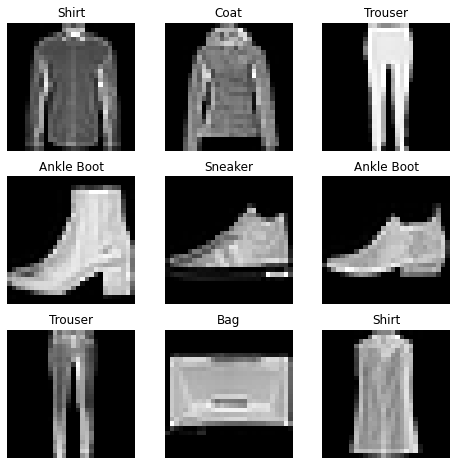

In [10]:
# 2. iterating and visualizing the dataset
# plt: figure -> subplot -> plt -> axis,title,imshow
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8)) # Create a new figure, or activate an existing figure.
cols, rows = 3, 3
for i in range(1, cols * rows + 1): # subplot index from 1 not 0
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # tensor生成随机整数，用于抽样
    img, label = training_data[sample_idx] # type: ignore # tuple unpack
    figure.add_subplot(rows, cols, i) # Create a figure containing a single axes in position (rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
# 我呆坐在椅子上，心想：不能吧。是的，不能不吃饭，路过的鸟儿善意提醒我。

In [11]:
# 3. creating a custom dataset for your files
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __inin__(self, annotations_file, img__dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img__dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
# 4. preparing your data for training with dataloaders
# The Dataset retrieves our dataset’s features and labels one(Dataset) sample at a time. While training a model, 
# we typically want to pass samples in “minibatches”(DataLoader), reshuffle the data at every epoch
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


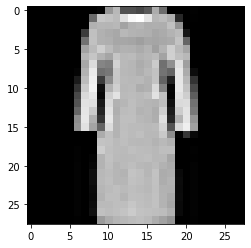

Label: 3


In [13]:
# 5. iterate through the dataloader
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")

## transforms

In [67]:
# all torchvison datasets have two parameters: transform and traget_transform
# use transforms to perform some manipulation of the data and make it suitable for training
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
# Lambda transforms apply any user-defined lambda function

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) # int to one-hot
)

In [68]:
# torch.Tensor.scatter_()把标量的标签转换为one-hot编码
class onehotScatter():
    def __init__(self, batch_size=4, class_num=5, labels=torch.tensor([4,0,1,2])):
        self.batch_size = batch_size
        self.class_num = class_num
        self.labels = torch.unsqueeze(labels, 1) # 扩展成二维
        self.one_hot = torch.zeros(batch_size, class_num)
        _dim = 1; _index_tensor = self.labels; _src = 1
        self.one_hot.scatter_(_dim, _index_tensor, _src)
        print(self.one_hot)

onehotScatter()

tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


## build model

In [1]:
# build the neural network
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# 1. get device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 2. define the class, nn.Module is directly inherit from class 'object', not isinstance of tensor
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.faltten = nn.Flatten() # start_dim: int = 1 end_dim=-1
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.faltten(x)
        print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits
    
# create an instance of NeuralNetwork and move to the device
model = NeuralNetwork().to(device) # to() defined in nn.Module
print(model) # __str__not exists, and execute nn.Module.__repr__()

# to use the model, pass it the inpyt data, auto execute forward() returna raw predicted values
X = torch.rand(1, 28, 28, device=device)
logits = model(X) # 默认model.training=True
print(logits)
pred_probab = nn.Softmax(dim=1)(logits) # range [0,1] and sum to 1
print(pred_probab)
y_pred = pred_probab.argmax(1) # return index
print(f"Predicted class: {y_pred}")

Using cuda device
NeuralNetwork(
  (faltten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
torch.Size([1, 784])
tensor([[-0.0848, -0.0506, -0.0014, -0.0202, -0.0349,  0.0420, -0.0501, -0.0389,
          0.0633, -0.0192]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0936, 0.0968, 0.1017, 0.0998, 0.0984, 0.1062, 0.0969, 0.0980, 0.1085,
         0.0999]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([8], device='cuda:0')


In [3]:
# 3. model layers

# break down the layers in the model, a sample minibatch of 3 images of size 28x28
# and see what happens to it as we pass it through the network
input_images = torch.rand(3, 28, 28)
print(input_images.size())

# 3.1 nn.flatten
flatten = nn.Flatten() # convert each 2D 28x28 image into a contiguous array of 784 pixel values, the minibatch dimension (at dim=0) is maintained
flat_image = flatten(input_images)
print(flat_image.size())

# 3.2 nn.Linear
layer1 = nn.Linear(in_features=28*28, out_features=20) # linear layer is a module that applies a linear transformation on the input
hidden1 = layer1(flat_image)
print(hidden1.size())

# 3.3 nn.ReLU
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1) # introduce non-linearity in your model, use nn.ReLU between our linear layers,
print(f"After ReLU: {hidden1}\n\n")

# 3.4 nn.Sequential
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10),
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

# 3.5 nn.Softmax
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[-1.4547e-01, -2.1345e-01,  2.8351e-01,  8.4186e-04, -4.1900e-01,
          2.9845e-01, -5.6992e-01,  2.9261e-01,  3.3209e-03, -1.4056e-01,
          3.6584e-01,  2.0745e-01,  3.9022e-02,  4.3132e-01, -6.3633e-02,
          7.8021e-01, -1.3780e-01,  1.1658e-01, -9.7171e-02, -3.3598e-01],
        [ 9.8997e-02, -1.7489e-01,  1.2345e-01,  2.6564e-01, -4.4254e-02,
          2.3046e-01, -1.4765e-01,  3.6650e-01, -2.6805e-02, -2.2589e-01,
         -8.8113e-02,  5.5007e-01,  3.5191e-01,  4.1690e-01, -1.5945e-01,
          8.8372e-01, -1.3807e-01, -3.4014e-02, -2.1347e-01, -4.9382e-01],
        [-2.2000e-01, -1.3019e-01,  1.5604e-01,  3.5273e-01, -3.9375e-01,
          6.6977e-02, -6.1013e-01, -3.6730e-02, -2.1297e-01,  1.7760e-01,
          2.1652e-01, -3.5736e-02,  2.6910e-01,  3.8336e-01, -1.7345e-01,
          5.0293e-01,  2.1078e-02, -9.9262e-02, -2.6981e-01, -2.5420e-01]],
       grad_fn=<AddmmBackward0

In [4]:
# 4. model parameters
print(f"Model struct: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}\n")

Model struct: NeuralNetwork(
  (faltten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0323, -0.0004,  0.0189,  ...,  0.0318, -0.0325, -0.0196],
        [ 0.0156,  0.0330, -0.0120,  ..., -0.0228,  0.0067, -0.0039]],
       device='cuda:0', grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0211,  0.0005], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0012,  0.0402, -0.0061,  ...,  0.0432, -0.0376,  0.0102],
        [ 0.0329,  0.0416, -0.0229,  ..., -0.0358, -0.0441,  0.0145]],
       device='cuda:0', grad_fn=<SliceBa

## autograd

In [32]:
# In back propagation algorithm, parameters (model weights) are adjusted according to 
# the gradient of the loss function with respect to the given parameter.
# automatic differentitatiom with torch.autograd for any computational graph

# Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
x,y,z

(tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0.]),
 tensor([-2.9735,  1.3257,  1.1707], grad_fn=<AddBackward0>))

In [25]:
z.backward(torch.ones_like(z)) # 测试从中间节点执行backward()自动梯度
w.grad, b.grad, z.grad_fn

(tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]),
 tensor([1., 1., 1.]),
 <AddBackward0 at 0x7ff987593460>)

In [28]:
# 清空叶子节点梯度
b.grad.zero_(), b.grad.zero_()

(tensor([0., 0., 0.]), tensor([0., 0., 0.]))

In [30]:
# A function that we apply to tensors to construct computational graph is in fact an object of class Function. 
# This object knows how to compute the function in the forward direction, 
# and also how to compute its derivative during the backward propagation step

# backward propagation function is stored in grad_fn property of a tensor
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7ff987593460>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7ff9873a6b50>


In [33]:
# compute the derivatives of our loss function with respect to parameters
# to compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad
loss.backward() # We can only perform gradient calculations using backward once on a given graph
# If we need to do several backward calls on the same graph, pass retain_graph=True to the backward call
print(w.grad)
print(b.grad)

tensor([[0.0162, 0.2634, 0.2544],
        [0.0162, 0.2634, 0.2544],
        [0.0162, 0.2634, 0.2544],
        [0.0162, 0.2634, 0.2544],
        [0.0162, 0.2634, 0.2544]])
tensor([0.0162, 0.2634, 0.2544])


In [35]:
# diable gradient tracking:1.mark as frozen parameters -> z.detach()
# 2. speed up computations when only doing forward pass -> with torch.no_grad():
z = torch.matmul(x, w)+b
print(z.requires_grad)
# 所有依赖于叶子节点张量的张量，其 requires_grad 属性必定是 True 的，但其梯度值只在计算过程中被用到，
# 不会最终存储到 grad 属性中。如果需要保留中间计算结果的梯度到 grad 属性中，可以使用 retain_grad 方法。 
# 如果仅仅是为了调试代码查看梯度值，可以利用 register_hook 打印日志

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [38]:
z = torch.matmul(x, w)+b
z_det = z.detach() # mark as frozen parameters stop gradient computing tracking
print(z_det.requires_grad)

False


In [40]:
# More on Computational Graphs, DAGs are dynamic in PyTorch.
# After each .backward() call, autograd starts populating a new graph
# Tensor Gradients and Jacobian Products
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t() # .t() transpose()二维简化版，转置二维张量
out.backward(torch.ones_like(out), retain_graph=True) # compute Jacobian Product, 标量和张量的自动梯度backward
# retain_graph=True 保持计算图
print(f"First call\n{inp.grad}")

out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")  # when doing backward propagation, PyTorch accumulates the gradients

inp.grad.zero_() # inp节点重置梯度值为0
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nThird call\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Third call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


## optimization

In [47]:
# Prerequiste Code for data and model construction
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [45]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [42]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [46]:
# initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [49]:
# Optimizer: optimization loop(epoch) -> training loop/validation or test loop -> batchsize to update parameters
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)   
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropage
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches    # 计算每batch的平均损失Avg loss
    correct /= size             # 计算%正确率
    print(f"Testor Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [50]:
# initialize the loss function and optimizer, and pass it to train_loop and test_loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")
# Accuracy: 70.9%, Avg loss: 0.783265 (epoch=20)

Epoch 1
--------------------------------------
loss: 2.301069    [    0/60000]
loss: 2.286863    [ 6400/60000]
loss: 2.269864    [12800/60000]
loss: 2.263703    [19200/60000]
loss: 2.238540    [25600/60000]
loss: 2.212242    [32000/60000]
loss: 2.223095    [38400/60000]
loss: 2.192458    [44800/60000]
loss: 2.196774    [51200/60000]
loss: 2.145911    [57600/60000]
Testor Error: 
 Accuracy: 51.7, Avg loss: 2.145273 

Epoch 2
--------------------------------------
loss: 2.162574    [    0/60000]
loss: 2.148090    [ 6400/60000]
loss: 2.096596    [12800/60000]
loss: 2.106218    [19200/60000]
loss: 2.054029    [25600/60000]
loss: 1.997180    [32000/60000]
loss: 2.028912    [38400/60000]
loss: 1.956131    [44800/60000]
loss: 1.970566    [51200/60000]
loss: 1.873679    [57600/60000]
Testor Error: 
 Accuracy: 54.6, Avg loss: 1.878449 

Epoch 3
--------------------------------------
loss: 1.923189    [    0/60000]
loss: 1.885918    [ 6400/60000]
loss: 1.778721    [12800/60000]
loss: 1.804792   

In [52]:
# warmstarting a model using parameters of a different model.
# set the strict argument to False in the load_state_dict() function to ignore non-matching keys

# Import necessary libraries for loading our data
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

In [66]:
# Define and intialize the neural network A and B
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

netA = NetA()

class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

netB = NetB()

In [23]:
from torch.utils.tensorboard import SummaryWriter
#在tensorboard中查看模型
writer = SummaryWriter('./data/tensorboard')
writer.add_graph(model, input_to_model = torch.randn(1,3,32,32)
writer.close()

In [22]:
torch.randn((2,4))

tensor([[-0.3643,  1.4855,  0.5947, -0.9331],
        [-1.0596, -0.3479, -1.4613, -0.3209]])

In [67]:
# Save model A
# Specify a path to save to
PATH = "model_NetA.pt"

torch.save(netA.state_dict(), PATH)

In [68]:
#  Load into model B
netB.load_state_dict(torch.load(PATH), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc3.weight', 'fc3.bias'])

In [85]:
# visualize netA in netron
netaJit = torch.jit.script(netA)     # need transform to torchscript
netaJit.save("netaJit.pth")

In [84]:
class NetronTest(nn.Module):
    def __init__(self):
        super(NetronTest, self).__init__()        

    def forward(self, x): 
        x = x * 2 
        x.add_(0) 
        x = x.view(-1) 
        if x[0] > 1: 
            return x[0] 
        else: 
            return x[-1]

netronTest = NetronTest()   # netronTest.state_dict() is empty, cannot recognized by netron directly
jit_script_model = torch.jit.script(netronTest)     # need transform to torchscript
jit_script_model.save("netronTestJit.pth")
# then upload file "netronTestJit.pth" to netron website: https://netron.app/, for visualization

## save and load the model

In [88]:
# persist model state with saving
import torch
import torchvision.models as models

In [89]:
model = models.vgg16(pretrained=True)
# learned parameters in an internal state dictionary, called state_dict
torch.save(model.state_dict(), "model_weights.pth")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/zhoujiaming/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [90]:
# To load model weights, you need to create an instance of the same model first, and then load the parameters 
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval() # all model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [91]:
# Saving and Loading Models with Shapes
# want to save the structure of this class together with the model, pass model (and not model.state_dict()) to the saving function
torch.save(model, "model_save.pth")

# load the model
model = torch.load("model_save.pth")
# This approach uses Python pickle module when serializing the model, 
# thus it relies on the actual class definition to be available when loading the model.

## end at 2023-2-5 22:29:42